In [1]:
# import 
# import wget # download files
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # customize the training
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore") 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet. 
Most of the sites don't have certification: `--no-check-certificate`

The date also available for manual download from
   `https://download.pytorch.org/tutorial/hymenoptera_data.zip`
   or 
   `https://www.kaggle.com/datasets/ajayrana/hymenoptera-data/`
   and extract it to the current directory.
 

Unzipping the data to the data folder:
`unzip hymenoptera_data.zip -d data`

The easiest way to get a testset is to create a `test` folder manualy move some image ther from the validationset and testset. 


In [2]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip --no-check-certificate
# !unzip hymenoptera_data.zip -d data

## Data augmentation 
- Augmentation and normalization for training - https://pytorch.org/vision/stable/transforms.html and https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
- Normalization for validation

In [3]:
Batch_size=64;

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(class_names)



['ants', 'bees']


### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations. Decrease the bach size for better visualisation.



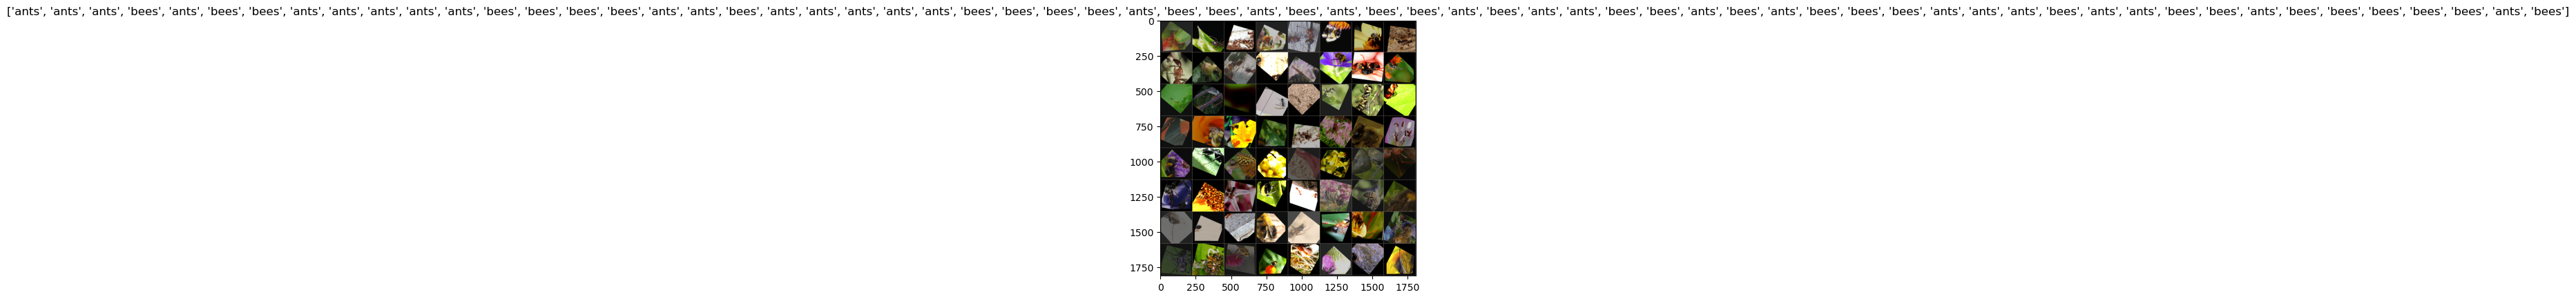

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_h=[]
    train_acc_h=[]
    for epoch in range(num_epochs):
      
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch, num_epochs - 1, scheduler.get_last_lr()[0]))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_acc_h.append(epoch_acc)
            # deep copy the model
            if phase == 'val':
                val_acc_h.append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

        print('Test started')
    phase == 'test'
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        test_loss = running_loss / dataset_sizes[phase]
        test_acc = running_corrects.double() / dataset_sizes[phase]
        
    time_elapsed = time.time() - since
    print('Training and testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Test Acc: {:4f}'.format(test_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_h, train_acc_h, test_acc

### Visualizing the model predictions

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Model overview: **ResNet18**

**ResNet18 Architecture**

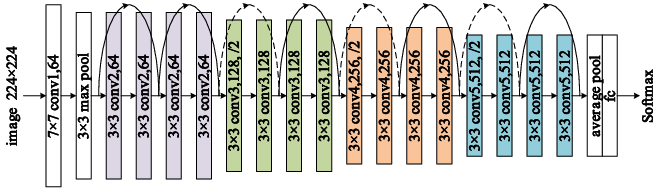

In [7]:
model = models.resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train the ConvNet from scratch

Everything from scratch - convolutional and fully connected

In [8]:
model = models.resnet18()
numrs = model.fc.in_features
# Here the size of the output is 2.
model.fc = nn.Linear(numrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
model, val_acc_h, train_acc_h, test_acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.000100
----------
train Loss: 0.7121 Acc: 0.5283
val Loss: 0.7592 Acc: 0.4380
Test started
Epoch 1/9 LR 0.000100
----------
train Loss: 0.7718 Acc: 0.5377
val Loss: 0.6740 Acc: 0.5455
Test started
Epoch 2/9 LR 0.000100
----------
train Loss: 0.6272 Acc: 0.6698
val Loss: 0.6422 Acc: 0.6116
Test started
Epoch 3/9 LR 0.000100
----------
train Loss: 0.7282 Acc: 0.5660
val Loss: 0.7056 Acc: 0.4876
Test started
Epoch 4/9 LR 0.000100
----------
train Loss: 0.7086 Acc: 0.5802
val Loss: 0.6734 Acc: 0.5785
Test started
Epoch 5/9 LR 0.000100
----------
train Loss: 0.6471 Acc: 0.6132
val Loss: 0.6824 Acc: 0.5620
Test started
Epoch 6/9 LR 0.000100
----------
train Loss: 0.6363 Acc: 0.6038
val Loss: 0.6926 Acc: 0.6033
Test started
Epoch 7/9 LR 0.000010
----------
train Loss: 0.6369 Acc: 0.5802
val Loss: 0.6988 Acc: 0.5950
Test started
Epoch 8/9 LR 0.000010
----------
train Loss: 0.6328 Acc: 0.6321
val Loss: 0.7012 Acc: 0.6116
Test started
Epoch 9/9 LR 0.000010
----------
train Loss: 0

In [10]:
def plot_acc(train_acc_h,val_acc_h, test_acc): 
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.title('Acc by Iteration')
    plt.plot(torch.tensor(train_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(val_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(test_acc, device = 'cpu')*100*np.ones(len(val_acc_h)))
    plt.ylim((50,100))
    plt.legend(['train', 'valid', 'test'])

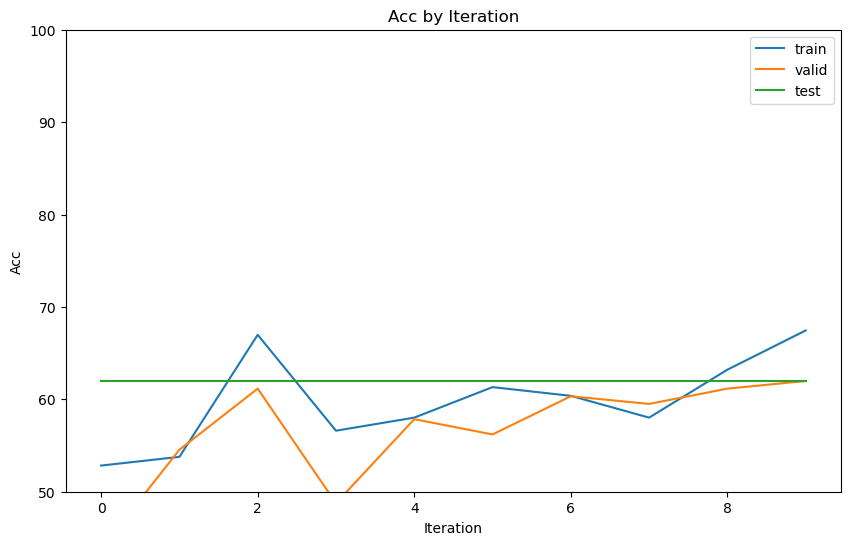

In [11]:
plot_acc(train_acc_h,val_acc_h, test_acc)

# Finetuning the ConvNet




Load a pretrained model and reset final fully connected layer.
we're training the whole network again WITH pretrained weights - Convolution and Fully Connected

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # BinaryCrossEntropyLoss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [13]:
model_ft, val_acc_h, train_acc_h, test_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.001000
----------
train Loss: 0.8849 Acc: 0.5047
val Loss: 0.7791 Acc: 0.5124
Test started
Epoch 1/9 LR 0.001000
----------
train Loss: 0.7543 Acc: 0.5236
val Loss: 0.7199 Acc: 0.5289
Test started
Epoch 2/9 LR 0.001000
----------
train Loss: 0.6279 Acc: 0.6698
val Loss: 0.4557 Acc: 0.8099
Test started
Epoch 3/9 LR 0.001000
----------
train Loss: 0.5239 Acc: 0.7783
val Loss: 0.3802 Acc: 0.8512
Test started
Epoch 4/9 LR 0.001000
----------
train Loss: 0.4491 Acc: 0.8255
val Loss: 0.3050 Acc: 0.9174
Test started
Epoch 5/9 LR 0.001000
----------
train Loss: 0.4052 Acc: 0.8255
val Loss: 0.2645 Acc: 0.9256
Test started
Epoch 6/9 LR 0.001000
----------
train Loss: 0.3767 Acc: 0.8302
val Loss: 0.2301 Acc: 0.9421
Test started
Epoch 7/9 LR 0.000100
----------
train Loss: 0.3309 Acc: 0.8774
val Loss: 0.2312 Acc: 0.9421
Test started
Epoch 8/9 LR 0.000100
----------
train Loss: 0.3695 Acc: 0.8538
val Loss: 0.2304 Acc: 0.9421
Test started
Epoch 9/9 LR 0.000100
----------
train Loss: 0

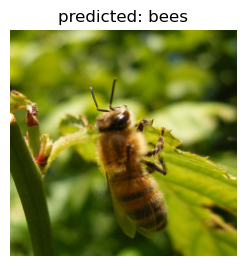

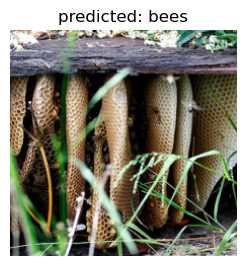

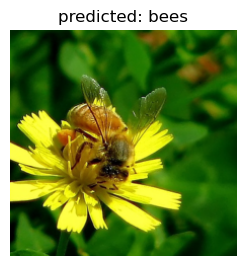

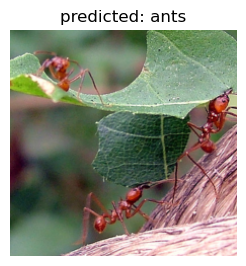

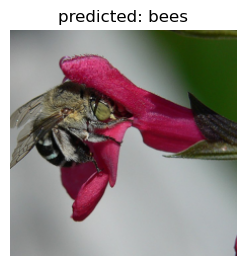

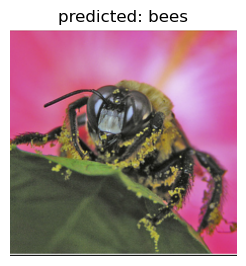

In [14]:
visualize_model(model_ft)

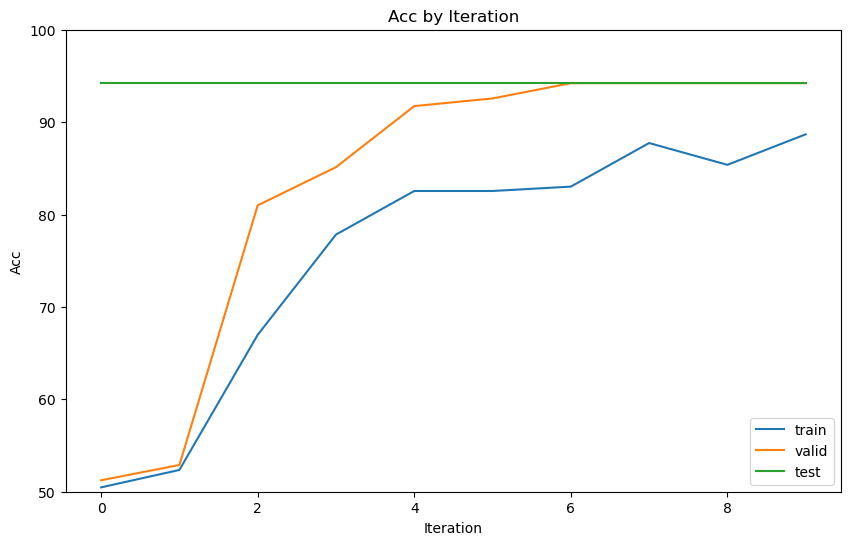

In [15]:
plot_acc(train_acc_h,val_acc_h, test_acc)

# ConvNet as fixed feature extractor - Transfer Learning!






Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

In [16]:
model_conv = torchvision.models.resnet18(pretrained=True) ## PRETRAINED!!!
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [17]:
model_conv, val_acc_h, train_acc_h, test_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9 LR 0.001000
----------
train Loss: 0.7184 Acc: 0.5519
val Loss: 0.5922 Acc: 0.7438
Test started
Epoch 1/9 LR 0.001000
----------
train Loss: 0.6659 Acc: 0.6132
val Loss: 0.5472 Acc: 0.7851
Test started
Epoch 2/9 LR 0.001000
----------
train Loss: 0.6296 Acc: 0.6321
val Loss: 0.4801 Acc: 0.8512
Test started
Epoch 3/9 LR 0.001000
----------
train Loss: 0.5735 Acc: 0.7547
val Loss: 0.4363 Acc: 0.8843
Test started
Epoch 4/9 LR 0.001000
----------
train Loss: 0.5595 Acc: 0.7264
val Loss: 0.3908 Acc: 0.8678
Test started
Epoch 5/9 LR 0.001000
----------
train Loss: 0.4886 Acc: 0.8255
val Loss: 0.3636 Acc: 0.9174
Test started
Epoch 6/9 LR 0.001000
----------
train Loss: 0.4637 Acc: 0.8255
val Loss: 0.3270 Acc: 0.9256
Test started
Epoch 7/9 LR 0.000100
----------
train Loss: 0.4007 Acc: 0.8726
val Loss: 0.3303 Acc: 0.9174
Test started
Epoch 8/9 LR 0.000100
----------
train Loss: 0.4656 Acc: 0.8208
val Loss: 0.3305 Acc: 0.9174
Test started
Epoch 9/9 LR 0.000100
----------
train Loss: 0

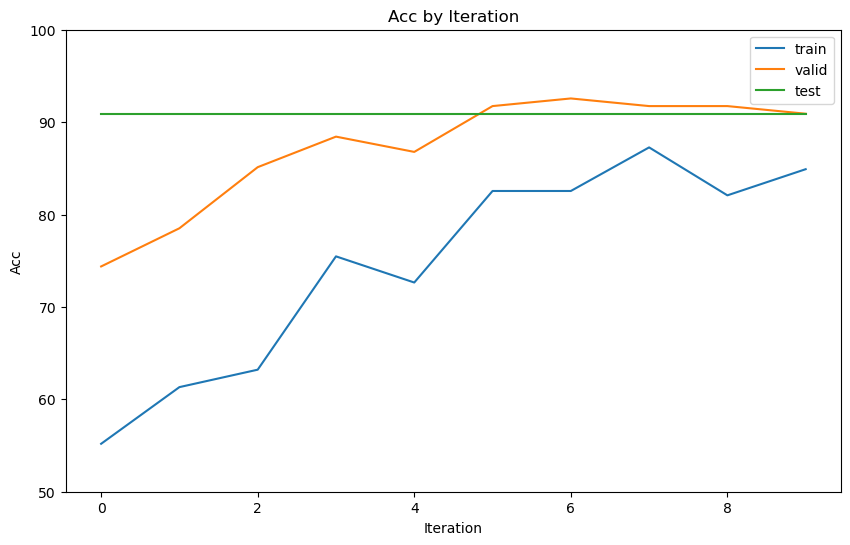

In [18]:
plot_acc(train_acc_h,val_acc_h, test_acc)

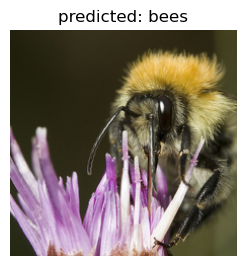

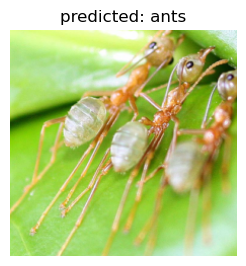

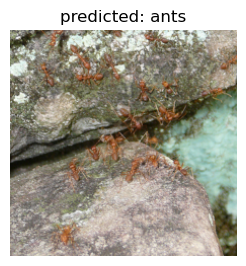

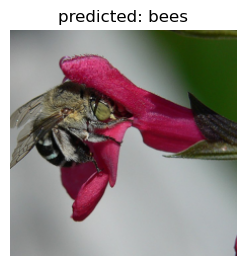

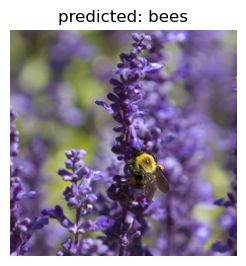

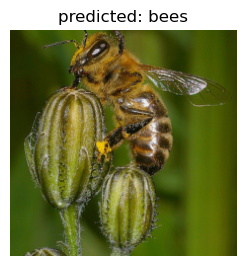

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# Then finetuning the entire network


In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True


# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_2 = optim.SGD(model_conv.fc.parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_2 = lr_scheduler.StepLR(optimizer_conv_2, step_size=7, gamma=0.1)

In [21]:
model_conv, val_acc_h, train_acc_h, test_acc = train_model(model_conv, criterion, optimizer_conv_2,
                         exp_lr_scheduler_2, num_epochs=10)

Epoch 0/9 LR 0.000010
----------
train Loss: 0.4271 Acc: 0.8726
val Loss: 0.3350 Acc: 0.9174
Test started
Epoch 1/9 LR 0.000010
----------
train Loss: 0.4360 Acc: 0.8443
val Loss: 0.3380 Acc: 0.9174
Test started
Epoch 2/9 LR 0.000010
----------
train Loss: 0.4363 Acc: 0.8302
val Loss: 0.3371 Acc: 0.9174
Test started
Epoch 3/9 LR 0.000010
----------
train Loss: 0.4601 Acc: 0.7972
val Loss: 0.3391 Acc: 0.9174
Test started
Epoch 4/9 LR 0.000010
----------
train Loss: 0.4153 Acc: 0.8491
val Loss: 0.3400 Acc: 0.9174
Test started
Epoch 5/9 LR 0.000010
----------
train Loss: 0.4422 Acc: 0.8113
val Loss: 0.3387 Acc: 0.9174
Test started
Epoch 6/9 LR 0.000010
----------
train Loss: 0.4163 Acc: 0.8491
val Loss: 0.3424 Acc: 0.9174
Test started
Epoch 7/9 LR 0.000001
----------
train Loss: 0.4406 Acc: 0.8491
val Loss: 0.3397 Acc: 0.9174
Test started
Epoch 8/9 LR 0.000001
----------
train Loss: 0.4370 Acc: 0.8255
val Loss: 0.3399 Acc: 0.9174
Test started
Epoch 9/9 LR 0.000001
----------
train Loss: 0

In [22]:
plot_acc(train_acc_h,val_acc_h, test_acc)

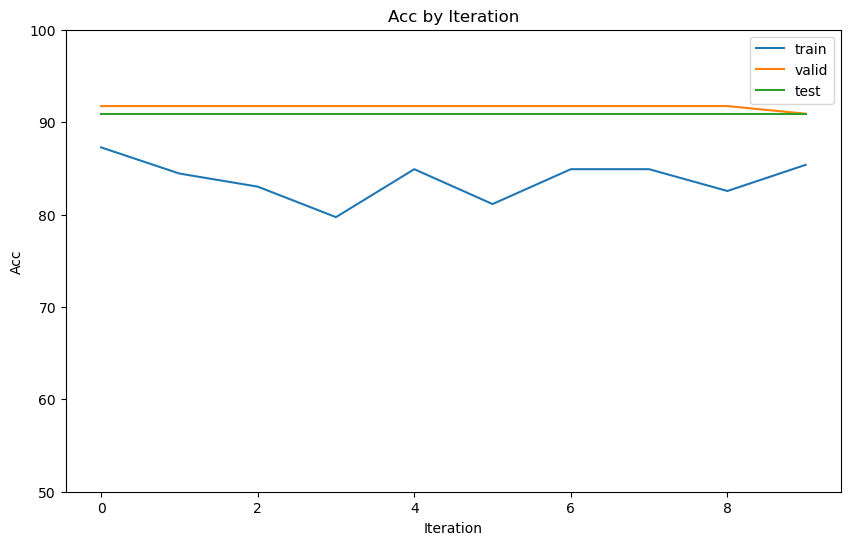

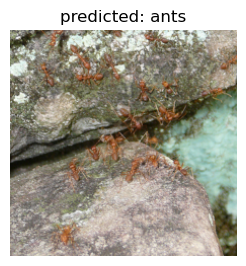

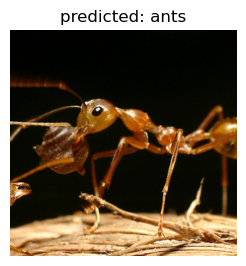

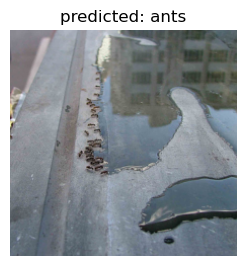

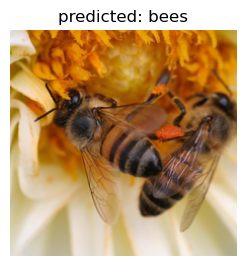

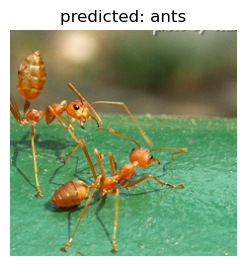

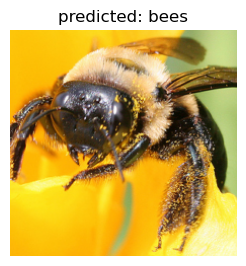

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

<div style="text-align: right">This lab is an extended version of Sasank Chilamkurthy's Pytorch: Transfer Learning for Computer Vision Tutorial.</div>